In [34]:
from sympy import *
import numpy as np
from itertools import combinations
import pandas as pd

from direct_lingam.ReLVLiNGAM import *
from direct_lingam.simulate_data import *
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)


(None, None)

Lambda is 
 [[0 0 0]
 [1 0 0]
 [0 1 0]]


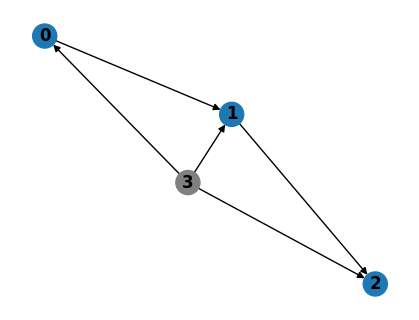

In [35]:
Lambda = get_Lambda([(1,0), (2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1], [1], [1]])
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [36]:
from direct_lingam.constraints_to_test import get_constraints_for_l_latents
class DiDLiNGAM(ReLVLiNGAM):
    def __init__(self,                 
                 *args,
                 **kwargs):
        """
        Initialize the DiDLiNGAM model.

        Parameters:
        *args: positional arguments
        **kwargs: keyword arguments
        """
        super().__init__(*args, **kwargs)
        self.cumulants = self._estimate_cumulants(self.X)
        self.roots_10 = self.__get__roots(i=1, j=0)
        self.roots_20 = self.__get__roots(i=2, j=0)
        
        

    def estimate_effect(self, method="cumulant", true_B = None):
        """
        Estimate the causal effect using the specified method.

        Parameters:
        method (str): The method to use for effect estimation. Can be "ratio" or "cumulant".

        Raises:
        ValueError: If the specified method is not supported.
        """
        if method == "ratio":
            matching_1 = [[self.roots_10[0], self.roots_20[0]], [self.roots_10[1], self.roots_20[1]]]
            matching_2 = [[self.roots_10[0], self.roots_20[1]], [self.roots_10[1], self.roots_20[0]]]
            matchings = [matching_1, matching_2]
            self.matchings = matchings
            self.causal_effect = self.__estimate__effect_ratio()
        elif method == "cumulant":
            marginal_omegas_10 = self.__marginal__cumulants(j=0, i=1)
            marginal_omegas_20 = self.__marginal__cumulants(j=0, i=2)
            match = self.__match__marginals(marginal_omegas_10, marginal_omegas_20)
            roots_1 = [self.roots_10[match[0][0]], self.roots_20[match[0][1]]]
            roots_2 = [self.roots_10[match[1][0]], self.roots_20[match[1][1]]]
            self.roots = [roots_1, roots_2]
            self.causal_effect = self.__estimate__effect_cumulant(roots_1, roots_2)
        elif method == "cumulant_with_true_matrix":
            self.causal_effect = self.__estimate__effect_cumulant(true_B[1:, 0], true_B[1:, 3])
        elif method == "ratio_after_matching":
            marginal_omegas_10 = self.__marginal__cumulants(j=0, i=1)
            marginal_omegas_20 = self.__marginal__cumulants(j=0, i=2)
            match = self.__match__marginals(marginal_omegas_10, marginal_omegas_20)
            self.causal_effect = self.__estimate__effect_ratio_after_matching(match)
        else:
            raise ValueError(f"Method {method} is not supported.")

    def __get__roots(self, i=1, j=0):
        """
        Get the roots of the polynomial equations for the specified nodes.

        Parameters:
        i (int): The index of the first node.
        j (int): The index of the second node.

        Returns:
        numpy.ndarray: The roots of the polynomial equations.
        """
        equations_bij = get_constraints_for_l_latents(1)["equations_bij"]

        eq = equations_bij[0]
        # eq = sum(equations_bij)

        # for eq in equations_bij:
        specify_nodes = {
            sym: symbols(
                sym.name[:2] + "".join(sorted(sym.name[2:].replace("j", str(j)).replace("i", str(i))))
            )
            for sym in reduce(set.union, [eq.free_symbols for eq in equations_bij])
            if str(sym) != "b_ij"
        }
        symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.cumulants, [i, j], scale_partly=False)
        estimated_coeffs = [float(coeff.subs(specify_nodes).subs(symbols_to_cumulants)) for coeff in eq.all_coeffs()]
        roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)
        # /len(equations_bij)
            
        return roots

    def __marginal__cumulants(self, j=0, i=1):
        """
        Estimate the marginal cumulants for the specified nodes.

        Parameters:
        j (int): The index of the first node.
        i (int): The index of the second node.

        Returns:
        numpy.ndarray: The estimated marginal cumulants.
        """
        source, other_node = j, i
        l = self.highest_l  # The number of latent variables confounding 1 and 2
        highest_order = 4  # Order up to which to estimate cumulants
        marginal_omegas = np.full((self.highest_l + 1, self.highest_order - 1), np.nan)
        # For k < l+1, the marginal omega cannot be inferred.
        for k in range(l + 1, highest_order + 1):
            roots = self.roots_10 if i == 1 else self.roots_20
            B_tilde = [roots ** i for i in range(k)]
            symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.cumulants, [i, j], scale_partly=False)
            y = np.array(
                [
                    float(symbols_to_cumulants[symbols(f"c_{''.join(sorted((str(source),) * (k - i) + (str(other_node),) * i))}")])
                    for i in range(k)
                ]
            )
            try:
                marginal_omegas[:, k - 2] = np.linalg.lstsq(B_tilde, y, rcond=None)[0]
            except np.linalg.LinAlgError:
                raise MathError(f"Linear system for {k}th order omega for source {source} and test node {other_node} is singular.")

        return marginal_omegas

    def __match__marginals(self, marginal_omegas_10, marginal_omegas_20):
        """
        Match the marginal cumulants of the two nodes.

        Parameters:
        marginal_omegas_10 (numpy.ndarray): The marginal cumulants of node 1.
        marginal_omegas_20 (numpy.ndarray): The marginal cumulants of node 2.

        Returns:
        list: The matching indices for the marginal cumulants.
        """
        if marginal_omegas_10.shape[0] != marginal_omegas_20.shape[0]:
            raise ValueError("The number of rows of the marginal omegas must be the same.")
        if marginal_omegas_10.shape[1] != marginal_omegas_20.shape[1]:
            raise ValueError("The number of columns of the marginal omegas must be the same.")        
        match_1, match_2 = [[0, 0], [1, 1]], [[0, 1], [1, 0]]
        dist_1 = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20)))
        dist_2 = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20[[1, 0]])))
        if dist_1 < dist_2:
            return match_1
        else:
            return match_2

    def __estimate__effect_cumulant(self, roots_1, roots_2):
        """
        Estimate the causal effect using the cumulant method.

        Parameters:
        match (list): The matching indices for the marginal cumulants.

        Returns:
        float: The estimated causal effect.
        """
        def ratio_formula(root, cov_matrix):
            return (cov_matrix[1, 2] - root * cov_matrix[0, 2]) / (cov_matrix[1, 1] - root * cov_matrix[0, 1])

        # Estimate the causal effect
        b_2 = ratio_formula(roots_1[0], self.cumulants.get(2))
        b_1 = ratio_formula(roots_2[0], self.cumulants.get(2))

        diff_1 = np.abs(roots_1[1] - b_1 * roots_1[0])
        diff_2 = np.abs(roots_2[1] - b_2 * roots_2[0])

        if np.argmin([diff_1, diff_2]) == 0:
            return b_1
        else:
            return b_2

    def __estimate__effect_ratio(self):
        """
        Estimate the causal effect using the ratio method.

        Returns:
        float: The estimated causal effect.
        """
        matchings = self.matchings
        ratios = []
        for matching in matchings:
            X_matching = []
            for pair in matching:
                X_pair = self.X.copy()
                X_pair[:, 1] -= self.X[:, 0] * pair[0]
                X_pair[:, 2] -= self.X[:, 0] * pair[1]
                X_matching.append(X_pair)

            var_1 = np.cov([X_matching[0][:, 1], X_matching[1][:, 1]])[0, 1]
            cov_1 = np.cov(X_matching[0][:, 1], X_matching[1][:, 2])[0, 1]
            cov_2 = np.cov(X_matching[1][:, 1], X_matching[0][:, 2])[0, 1]
            
            ratio = sorted([cov_1/var_1, cov_2/var_1], key = abs)            
            ratios.append(ratio)
        
        diff_ratios = [np.abs(r[1] - r[0]) for r in ratios]
        # return np.mean(ratios[diff_ratios.index(min(diff_ratios))])
        return np.mean(ratios[np.argmin(diff_ratios)])

        
        
    
    def __estimate__effect_ratio_after_matching(self, match):
        """
        Estimate the causal effect using the latent factor method.
        
        Parameters:
        match (list): The matching indices for the marginal cumulants.
        
        Returns:
        float: The estimated causal effect.
        """
        
        roots_1 = [self.roots_10[match[0][0]], self.roots_20[match[0][1]]]
        roots_2 = [self.roots_10[match[1][0]], self.roots_20[match[1][1]]]
        roots = [roots_1, roots_2]
        X_regs = []
        for root in roots:
            X_pair = self.X.copy()
            X_pair[:, 1] -= self.X[:, 0] * root[0]
            X_pair[:, 2] -= self.X[:, 0] * root[1]
            X_regs.append(X_pair)
         
        var_1 = np.cov([X_regs[0][:, 1], X_regs[1][:, 1]])[0, 1]
        cov_1 = np.cov(X_regs[0][:, 1], X_regs[1][:, 2])[0, 1]
        cov_2 = np.cov(X_regs[1][:, 1], X_regs[0][:, 2])[0, 1]
        
            
        return  np.mean([cov_1/var_1, cov_2/var_1])

In [37]:
def get_ratio_(Z, D, deg=2):
    """
    Computes ratio between alpha_d/alpha_z

    Parameters:
        - Z (np.array): proxy variable observations
        - D (np.array): treatment observations
        - deg (int): moment of non-guassianity (equal to the (n-1) from the original paper)
    """
    var_u = np.mean(Z*D)
    sign = np.sign(var_u)
    
    diff_normal_D = np.mean(D**(deg)*Z) - deg*var_u*np.mean(D**(deg-1))
    diff_normal_Z = np.mean(Z**(deg)*D) - deg*var_u*np.mean(Z**(deg-1))
    
    alpha_sq = ((diff_normal_D) / (diff_normal_Z))
    if alpha_sq < 0:
        alpha_sq = -(abs(alpha_sq)**(1/(deg-1)))
    else:
        alpha_sq = alpha_sq**(1/(deg-1))
    alpha_sq = abs(alpha_sq)*sign
    
    return alpha_sq


def cross_moment(Z, D, Y, deg=2):
    """
    Cross-Moment method implementation

    Parameters:
        - Z (np.array): proxy variable observations
        - D (np.array): treatment observations
        - Y (np.array): outcome observations
        - deg (int): moment of non-guassianity (equal to the (n-1) from the original paper)
    """
    denominator = 0
    while denominator==0:
        alpha_sq = get_ratio_(Z, D, deg)
        numerator = np.mean(D*Y) - alpha_sq*np.mean(Y*Z)
        denominator = np.mean(D*D) - alpha_sq*np.mean(D*Z)
        deg += 1
    return numerator / denominator

In [40]:
import concurrent.futures
from scipy.linalg import norm


def eval_matching(roots, true_B):
    return min([norm(roots[0]-true_B[1:,0], 1)/norm(true_B[1:,0], 1) + norm(roots[1]-true_B[1:,3], 1)/norm(true_B[1:,3], 1), norm(roots[1]-true_B[1:,0], 1)/norm(true_B[1:,0], 1) + norm(roots[0]-true_B[1:,3], 1)/norm(true_B[1:,3], 1)])/2
reps = 30
seeds_df = []
parameter_sets = list(range(2*reps, 4*reps))

def run_experiment(seed):
    # run the experiment using the given parameters
        # Set the random seed
    noise_distribution = 'gamma'
    samples_sizes = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]

    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = true_B[2, 1]
    
    # Perform the experiment
    causal_effect_estimates_cumulant, causal_effect_estimates_ratio_test, causal_effect_estimates_ratio_after, causal_effect_estimates_cm = [], [], [], []   
    causal_effect_estimates_cumulant_with_true_matrix, roots_estimates_error, matching_estimates_error = [], [], []
    
    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        
        did_model = DiDLiNGAM(X_sample, highest_l = 1)
        did_model.estimate_effect("cumulant")
        causal_effect_estimate_cumulant = did_model.causal_effect
        causal_effect_estimates_cumulant.append(causal_effect_estimate_cumulant)
        roots = did_model.roots
        roots_estimates_error.append(eval_matching(roots, true_B))
        
        did_model.estimate_effect("cumulant_with_true_matrix", true_B = true_B + np.random.uniform(-1/sqrt(n), 1/sqrt(n), size=(3, 4)))
        causal_effect_estimate_cumulant = did_model.causal_effect
        causal_effect_estimates_cumulant_with_true_matrix.append(causal_effect_estimate_cumulant)    
        
        did_model.estimate_effect("ratio")
        causal_effect_estimate_ratio_test = did_model.causal_effect
        causal_effect_estimates_ratio_test.append(causal_effect_estimate_ratio_test)
        matchings = did_model.matchings
        matching_estimates_error.append(min([eval_matching(matchings[0], true_B), eval_matching(matchings[1], true_B)]))
        
        
        did_model.estimate_effect("ratio_after_matching")
        causal_effect_estimate_ratio_after = did_model.causal_effect
        causal_effect_estimates_ratio_after.append(causal_effect_estimate_ratio_after)
        
        cross_moment_estimate = cross_moment(X_sample[:, 0], X_sample[:, 1], X_sample[:, 2])
        causal_effect_estimates_cm.append(cross_moment_estimate)
    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect': [causal_effect_true] * len(samples_sizes),
        'Root Error': roots_estimates_error,
        'Match Error': matching_estimates_error,
        'Causal Effect Estimate (Cumulant)': causal_effect_estimates_cumulant,
        'Causal Effect Estimate (Cumulant With True Matrix)': causal_effect_estimates_cumulant_with_true_matrix,
        'Causal Effect Estimate (Ratio Test)': causal_effect_estimates_ratio_test,
        'Causal Effect Estimate (Ratio Test After Matching)': causal_effect_estimates_ratio_after,
        'Cross Moment': causal_effect_estimates_cm
    })
    return seed_df


# create a list to store the results


# create a thread pool executor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # submit each experiment to the executor
    print(f"Using {executor._max_workers} processes")
    futures = [executor.submit(run_experiment, params) for params in parameter_sets]

    # wait for all experiments to complete and store the results
    for future in concurrent.futures.as_completed(futures):
        seeds_df.append(future.result())

# process the results as needed
results_df = pd.concat(seeds_df, ignore_index=True)

Using 12 processes


/var/folders/nd/nn8th6r16cq6sytrzw1nw_9w0000gn/T/ipykernel_98327/1039202608.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)


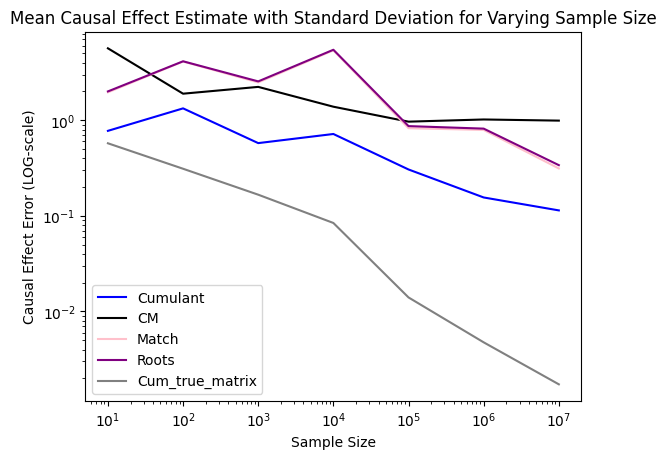

In [39]:
import matplotlib.pyplot as plt

results_df["Cumulant Error"] = np.abs((results_df['Causal Effect Estimate (Cumulant)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
results_df["Ratio Test Error"] = np.abs((results_df['Causal Effect Estimate (Ratio Test)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
results_df["Ratio Test After Matching Error"] = np.abs((results_df['Causal Effect Estimate (Ratio Test After Matching)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
results_df["Cumulant Error With True Matrix"] = np.abs((results_df['Causal Effect Estimate (Cumulant With True Matrix)'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
results_df["CM Error"] = np.abs((results_df['Cross Moment'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error

# Group the results by sample size and calculate the mean
mean_results = results_df.groupby('Sample Size').mean()
mean_sd = results_df.groupby('Sample Size').std()

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(mean_results.index, mean_results["Cumulant Error"],
         label='Cumulant',
         color = "blue")

# plt.plot(mean_results.index, mean_results["Ratio Test Error"],
#          label='Ratio Test',
#          color = "red")

# plt.plot(mean_results.index, mean_results["Ratio Test After Matching Error"],
#          label='Ratio Test After Matching Error',
#          color = "green")

plt.plot(mean_results.index, mean_results["CM Error"],
         label='CM',
         color = "black")

plt.plot(mean_results.index, mean_results["Match Error"],
         label='Match',
         color = "pink")

plt.plot(mean_results.index, mean_results["Root Error"],
         label='Roots',
         color = "purple")

plt.plot(mean_results.index, mean_results["Cumulant Error With True Matrix"],
         label='Cum_true_matrix',
         color = "grey")

# plt.fill_between(mean_results.index,
#                  mean_results['Cumulant Error'] + mean_sd['Cumulant Error'],
#                  mean_results['Cumulant Error'] - mean_sd['Cumulant Error'],
#                  color = "blue",
#                  alpha=0.2)


# plt.fill_between(mean_results.index, 
#                  mean_results['Ratio Test Error'] + mean_sd['Ratio Test Error'], 
#                  mean_results['Ratio Test Error'] - mean_sd['Ratio Test Error'],
#                  alpha=0.2, 
#                  color = "red")


# plt.fill_between(mean_results.index,
#                  mean_results['Latent Factor Error'] + mean_sd['Latent Factor Error'],
#                  mean_results['Latent Factor Error'] - mean_sd['Latent Factor Error'],
#                  alpha=0.2,
#                  color = "green")


# plt.fill_between(mean_results.index, 
#                  mean_results['CM Error'] + mean_sd['CM Error'], 
#                  mean_results['CM Error'] - mean_sd['CM Error'],
#                  alpha=0.2, 
#                  color = "black")



plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Mean Causal Effect Estimate with Standard Deviation for Varying Sample Size')
plt.show()